In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.metrics import pairwise_distances

In [2]:
format_plots()
#format_pizza_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "age_vs_behavioral_age", tight_layout=False)

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            #cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            cohort_dist[x,y]=scipy.spatial.distance.jensenshannon(p=np.array(i), q=np.array(j))
            
            y=y+1
        y=0
        x=x+1
    #cohort_dist[cohort_dist==0]='nan'
    return cohort_dist

In [5]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df = pd.read_parquet(path)

In [6]:
## update data
def remove_crl(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    #df.drop('m05_c02_b01_s01', level=1, axis=0, inplace=True)
    #df.drop('a85e0616-6a5b-4dd8-a2d6-51701084c25e',level=3, axis=0, inplace=True)
    #df.drop('b365ea6a-369f-4991-b139-15694dc1c86d',level=3, axis=0, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
# arrange age data
data= remove_crl(df)
age_data=data.copy()
ages=age_data.index.get_level_values(0)
age_data=age_data.reset_index()

#prepare data
mapd = {3: 0, 
       5: 1, 
       7: 2,
       9: 3,
       12: 4,
       24: 5,
       36: 6,
       52: 7,
       78: 8,
       90: 9,
       }
#age_data['bins'] = pd.qcut(age_data['age'], len(ages.unique()),labels=False)
#age_data['bins'] = pd.cut(age_data['age'], bins=len(ages.unique()),labels=False)

age_data['bins'] = age_data['age'].map(mapd)
age_data.set_index('bins', inplace=True)
age_data = age_data.filter(regex=r'\d')

In [8]:
# pseudo data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
df_psd = pd.read_parquet(path)
df_psd=df_psd.reset_index()
df_psd=df_psd[['uuid','pseudotime_rank']]
df_psd = pd.merge(data.reset_index(),df_psd,how='left',on=['uuid'])
## create bins
df_psd['bins'] = pd.qcut(df_psd['pseudotime_rank'], len(ages.unique()),labels=False)
df_psd.set_index('bins', inplace=True)
psd_data = df_psd.filter(regex=r'\d')

In [9]:
# calculate distance for chronological age and pseudo age
# for age
bins=[]
kld_age=[]
u_age=[]
c_age=[]
exp=[]
for age,_df in enumerate(age_data.groupby('bins')):
    bins.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [10]:
# calculate distance for chronological age and pseudo age
# for age
kld_psd=[]
u_psd=[]
c_psd=[]
for age,_df in enumerate(psd_data.groupby('bins')):
    bins.extend(_df[1].index.get_level_values(0).to_numpy())
    exp.extend(['psd']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_psd.extend(np.mean(kld_temp, axis=1))
    u_psd.extend(np.mean(utemp, axis=1))
    c_psd.extend(np.mean(ctemp, axis=1))

In [11]:
df=pd.DataFrame()
df['bins']=bins
df['kld']=np.append(kld_age,kld_psd)
df['exp']=exp
df['euc']=np.append(u_age,u_psd)
df['cosine']=np.append(c_age,c_psd)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

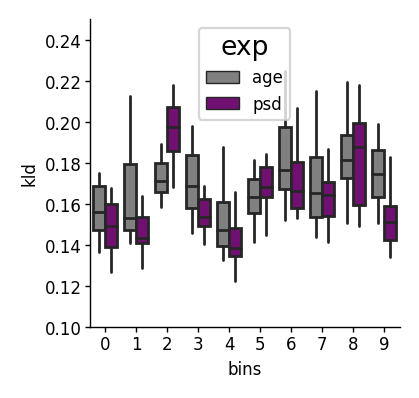

In [12]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="kld", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.1,0.25)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'jsd_within_age_compare.pdf', bbox_inches='tight')
#plt.savefig(data_loc +'ontogeny_kld_female_line.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

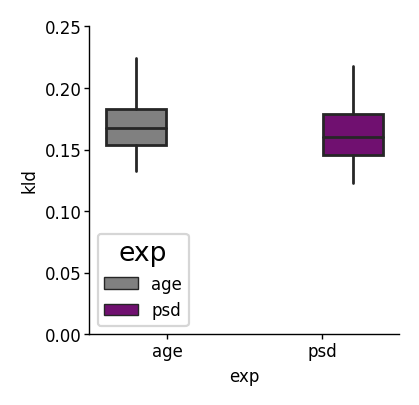

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="kld", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.0,0.25)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

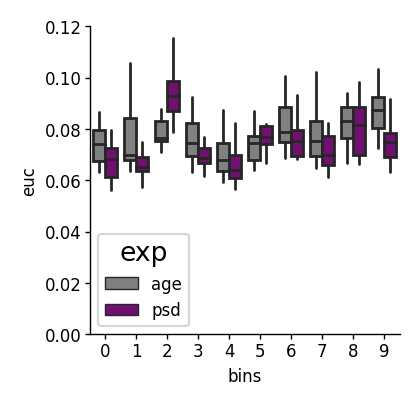

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="euc", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.0,0.12)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

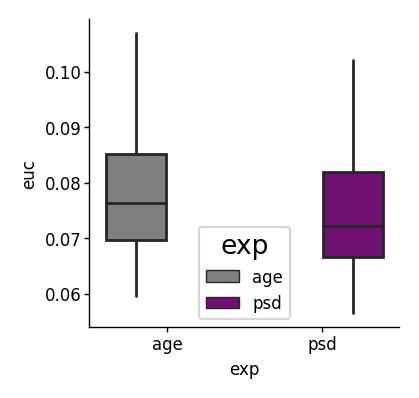

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="euc", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.12)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

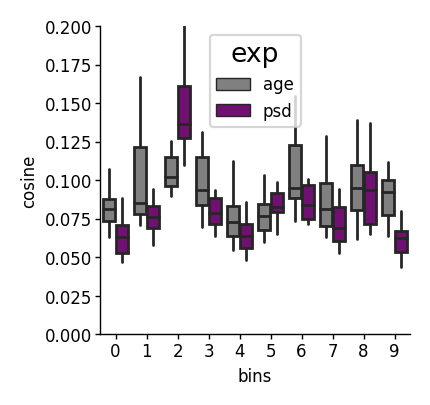

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="cosine", hue='exp', 
            #notch= True,
            showmean = False,
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.0,0.2)
sns.despine()

c = PlotConfig()
fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'cosine_within_age_compare.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

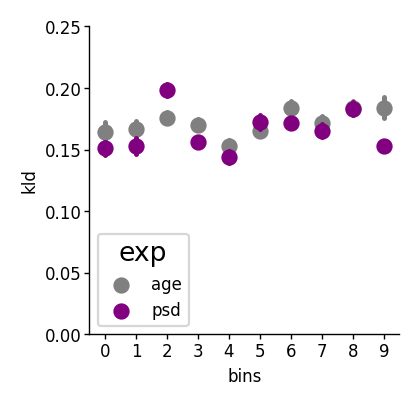

In [33]:
## show mean

fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="kld", hue='exp', 
            #notch= True,
            estimator='mean',
            errorbar = 'se',
            palette = ['grey','purple'], 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.0,0.25)
sns.despine()

#c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'cosine_within_age_compare.pdf', bbox_inches='tight')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

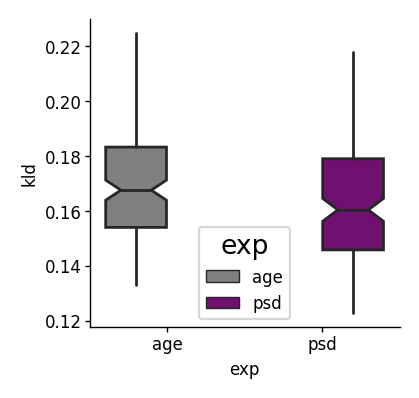

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="kld", hue='exp', 
               notch=True,
               palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.15)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

In [29]:
## same but for PC

In [30]:
## same for variacne over pc1
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_v2.parquet')
df = pd.read_parquet(path)

#prepare data
mapd = {3: 0, 
       5: 1, 
       7: 2,
       9: 3,
       12: 4,
       24: 5,
       36: 6,
       52: 7,
       78: 8,
       90: 9,
       }

# arrange age data
data= remove_crl(df)
age_data=data.copy()
ages=age_data.index.get_level_values(0)
age_data=age_data.reset_index()

age_data['bins'] = age_data['age'].map(mapd)
#age_data.set_index('bins', inplace=True)
#age_data = age_data.filter(regex=r'\d')

In [31]:
pca = PCA(n_components=10)

# Fit PCA to your data
pcs = pca.fit_transform(np.log(age_data.filter(regex=r'\d') + 1e-6))
pc_df = pd.DataFrame(pcs)
pc_df['age'] = age_data['age']

In [32]:
explained_variance_ratio = pca.explained_variance_ratio_
# Calculate the cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumulative_variance_ratio)
# Print the explained variance ratio for each PC
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1} Explained Variance Ratio: {ratio:.4f}")

[0.53928404 0.68799097 0.74858636 0.78921933 0.82022999 0.84762051
 0.87222518 0.88909456 0.9043423  0.9171157 ]
PC1 Explained Variance Ratio: 0.5393
PC2 Explained Variance Ratio: 0.1487
PC3 Explained Variance Ratio: 0.0606
PC4 Explained Variance Ratio: 0.0406
PC5 Explained Variance Ratio: 0.0310
PC6 Explained Variance Ratio: 0.0274
PC7 Explained Variance Ratio: 0.0246
PC8 Explained Variance Ratio: 0.0169
PC9 Explained Variance Ratio: 0.0152
PC10 Explained Variance Ratio: 0.0128


In [33]:
#upload pseudo age
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/ontogeny_males_clean_pseudotime_v02.parquet')
df_psd = pd.read_parquet(path)
df_psd=df_psd.reset_index()
df_psd=df_psd[['uuid','pseudotime_rank']]
df_psd = pd.merge(age_data.reset_index(),df_psd,how='left',on=['uuid'])
df_psd['bins'] = pd.qcut(df_psd['pseudotime_rank'], len(ages.unique()),labels=False)
pc_df['psd'] = df_psd['pseudotime_rank']
pc_df['psd_bins'] = df_psd['bins']
pc_df['age_bins'] = age_data['age'].map(mapd)

In [34]:
# calculate distance for chronological age and pseudo age
# for age
bins=[]
u_age=[]
u_psd=[]
exp=[]
for age,_df in enumerate(pc_df.groupby('age_bins')):
    bins.extend(_df[1]['age_bins'].to_numpy())
    exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].filter(regex=r'\d').to_numpy()
    utemp = pairwise_distances(data_temp)
    u_age.extend(np.mean(utemp, axis=1))
    

for age,_df in enumerate(pc_df.groupby('psd_bins')):
    bins.extend(_df[1]['psd_bins'].to_numpy())
    exp.extend(['psd']*len(_df[1]))
    data_temp = _df[1].filter(regex=r'\d').to_numpy()
    utemp = pairwise_distances(data_temp)
    u_psd.extend(np.mean(utemp, axis=1))

In [35]:
df=pd.DataFrame()
df['bins']=bins
df['exp']=exp
df['euc']=np.append(u_age,u_psd)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

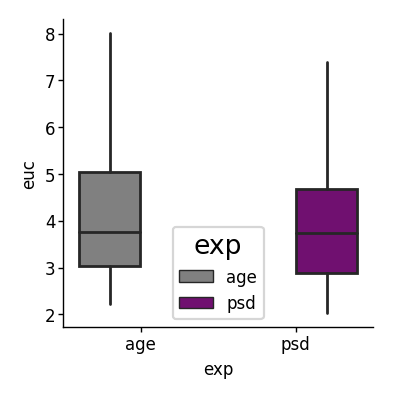

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="euc", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.12)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')